In [1]:
import numpy as np
from math import e
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from itertools import product

%matplotlib inline

**I'm currently assuming player and oppponent strategy sets are the same.**

In [2]:
def simulate_decision(strats=list(range(20,100,10)), T=10, payoff_func=None, _lambda=1, 
                      sigmas=0, gamma=11):
    """
    strats: list-like of elements which payoff_func can take.

    T: integer, number of times to update both player and opponent strategy activations
    
    payoff_func: function taking player_strategy, opponent_strategy, for traveler's dilemma,
    must also specify gamma, a reward/penalty parameter.
    
    `_lambda`: float. _lambda is a 'stochasticity parameter'. If it's 0, strategies are sampled 
    from a uniform distribution despite their activations. If `_lambda` is very high, the most 
    active strategy is always chosen.

    `_sigma`: list-like of floats or ints governing the salience (bias) of different strategies.
            or 0.
    """
    if sigmas == 0:
        sigmas = np.zeros(len(strats))
    
    player_strategy_activations   = np.zeros(len(strats))
    opponent_strategy_activations = np.zeros(len(strats))
    
    for t in range(T):
        for strat_acts in [opponent_strategy_activations, player_strategy_activations]:
            num = e**(_lambda*(strat_acts + sigmas))
            dist_over_strats = num / num.sum()
            sampled_strat = np.random.choice(a=strats, p=dist_over_strats)

            player_utilities = [payoff_func(player_strat=x,
                                            opponent_strat=sampled_strat,
                                            gamma=gamma) for x in strats]
            strat_acts += player_utilities

    decision = strats[np.argmax(player_strategy_activations)]
    return decision

# Traveler's Dilemma

In the traveler's dilemma, payoffs depend ona  reward/penalty parameter, `_gamma`, which controls how much each player is rewarded/penalized for under/over-bidding.

In [3]:
def travelers_dillema_payoffs(player_strat, opponent_strat, gamma):
    """
    returns only the player_payoff
    """
    if player_strat > opponent_strat:
        return 0.01*(opponent_strat - gamma)
    elif player_strat == opponent_strat:
        return 0.01*player_strat
    else:
        return 0.01*(player_strat + gamma)

In [4]:
simulate_decision(payoff_func=travelers_dillema_payoffs)

80

100%|██████████| 3000/3000 [00:05<00:00, 570.15it/s]


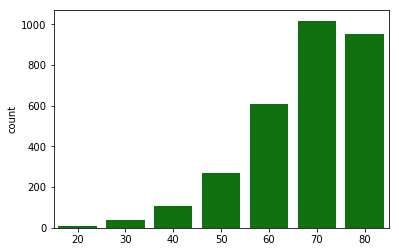

In [5]:
results = []
for _ in tqdm(range(3000)):
    result = simulate_decision(payoff_func=travelers_dillema_payoffs, T=10)
    results.append(result)
    
results = pd.Series(results)
sns.countplot(x=results, color='green');

In [6]:
Ts       = [10, 20, 30]
_lambdas = [.25, .5, 1, 2, 4]
gammas   = [11, 19]

sim_count = 3000

This next cell takes about 5 minutes -- there are 30 combinations of the above parameter settings, so the below will need to execute 30 loops.

In [7]:
parameter_sweep_results = []
for T, _lambda, gamma in tqdm(product(Ts, _lambdas, gammas)):
    for _ in range(sim_count):
        strategy = simulate_decision(payoff_func=travelers_dillema_payoffs, T=T, 
                                     _lambda=_lambda, gamma=gamma)
        parameter_sweep_results.append([T, _lambda, gamma, strategy])

30it [04:53,  9.79s/it]


In [8]:
parameter_sweep_results = pd.DataFrame(data=parameter_sweep_results, columns=['T', 'lambda', 'gamma', 'strategy'])
parameter_sweep_results.head()

,T,lambda,gamma,strategy
0,10,0.25,11,80
1,10,0.25,11,50
2,10,0.25,11,70
3,10,0.25,11,60
4,10,0.25,11,20


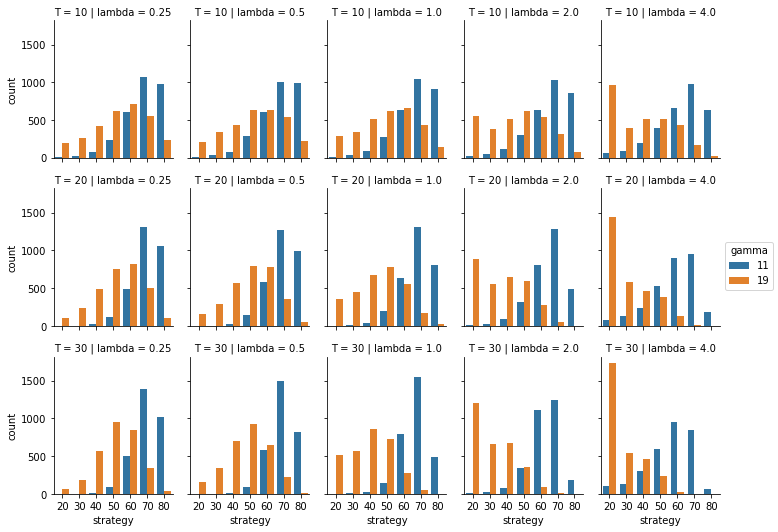

In [10]:
sns.factorplot(x="strategy", col="lambda", row="T", hue="gamma", 
               data=parameter_sweep_results, kind="count", size=2.5, aspect=.8);